In [48]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import spatialpower.neighborhoods.permutationtest as perm_test
import tqdm


In [3]:
df = pd.read_csv('/Users/ethan/Dropbox (MIT)/Lab/spatial-data-generation_brokengit/circle_packing/spleen_data/CODEX_MRLdataset_neighborhood_graph.csv', header = 0)


In [4]:
balbc1 = df[df['Cell1 Sample_Xtile_Ytile'].str.startswith('BALBc-1')]
tile_names = np.sort(balbc1['Cell1 Sample_Xtile_Ytile'].unique())

In [5]:
x_boundary = 0
x_adjustments = dict()
y_boundary = 0
y_adjustments = dict()

for x in range(1, 7):
    
    if x == 1:
        x_adjustments[x] = 0
   
    key = 'BALBc-1_X0' + str(x) + '_Y01'
    max_x = max(balbc1[balbc1['Cell1 Sample_Xtile_Ytile'] == key]['X1'])
    x_boundary += max_x
    x_adjustments[x + 1] = x_boundary

for y in range(1,9):
    
    if y == 1:
        y_adjustments[y] = 0
    
    key = 'BALBc-1_X01_Y0' + str(y)
    max_y = max(balbc1[balbc1['Cell1 Sample_Xtile_Ytile'] == key]['Y1'])
    y_boundary += max_y
    y_adjustments[y + 1] = y_boundary
    

df['X1_adjusted'] = np.NaN
df['Y1_adjusted'] = np.NaN

for tile in tile_names:
    df[df['Cell1 Sample_Xtile_Ytile'] == tile]

In [7]:
def adjust_x(key):
    #key = z['Cell1 Sample_Xtile_Ytile'].to_list()[0]
    x = int(key.split('_')[1].split('X')[1])
    #y = int(key.split('_')[2].split('Y')[1])
    adjustment = x_adjustments[x]
    return adjustment

def adjust_y(key):
    #key = z['Cell1 Sample_Xtile_Ytile'].to_list()[0]
    #x = int(key.split('_')[1].split('X')[1])
    y = int(key.split('_')[2].split('Y')[1])
    adjustment = y_adjustments[y]
    return adjustment

def make_identifier(df):
    str_id = df.apply(lambda x: '_'.join(map(str, x)), axis=1)
    return str_id


In [8]:
df['X1_adjusted'] = df['X1'] + df['Cell1 Sample_Xtile_Ytile'].apply(adjust_x)
df['Y1_adjusted'] = df['Y1'] + df['Cell1 Sample_Xtile_Ytile'].apply(adjust_y)
df['X2_adjusted'] = df['X2'] + df['Cell2 Sample_Xtile_Ytile'].apply(adjust_x)
df['Y2_adjusted'] = df['Y2'] + df['Cell2 Sample_Xtile_Ytile'].apply(adjust_y)

source = df['Cell1 Imaging phenotype cluster ID'].tolist()
sink = df['Cell2 Imaging phenotype cluster ID'].tolist()

source_x_positions = df['X1_adjusted'].tolist()
source_y_positions = df['Y1_adjusted'].tolist()
sink_x_positions = df['X2_adjusted'].tolist()
sink_y_positions = df['Y2_adjusted'].tolist()

df['source_cell_ID'] = make_identifier(df[['X1_adjusted','Y1_adjusted']])
df['sink_cell_ID'] = make_identifier(df[['X2_adjusted','Y2_adjusted']])

source_id = df['source_cell_ID'].tolist()
sink_id = df['sink_cell_ID'].tolist()
unique_ids = np.unique(source_id)
new_ID = [i for i in range(0, len(unique_ids))]
new_id_dict = dict(zip(unique_ids, new_ID))
df['source_id'] = df['source_cell_ID'].map(new_id_dict)
df['sink_id'] = df['sink_cell_ID'].map(new_id_dict)
df.tail()

Cell1 Sample_Xtile_Ytile   X1   Y1  \
4310493            MRL-5_X04_Y09  550  471   
4310494            MRL-5_X04_Y09  232  614   
4310495            MRL-5_X04_Y09  236  624   
4310496            MRL-5_X04_Y09  973  980   
4310497            MRL-5_X04_Y09  550  471   

         Cell1 Imaging phenotype cluster ID Cell2 Sample_Xtile_Ytile    X2  \
4310493                                9595            MRL-5_X04_Y09   509   
4310494                                9613            MRL-5_X04_Y09   201   
4310495                                9596            MRL-5_X04_Y09   247   
4310496                                9619            MRL-5_X04_Y09  1024   
4310497                                9595            MRL-5_X04_Y09   542   

          Y2  Cell2 Imaging phenotype cluster ID  X1_adjusted  Y1_adjusted  \
4310493  464                                9613         4569         8506   
4310494  600                                9613         4251         8649   
4310495  639                                9613         4255         8659   
4310496  972                                9619         4992         9015   
4310497  443                                9613         4569         8506   

         X2_adjusted  Y2_adjusted source_cell_ID sink_cell_ID  source_id  \
4310493         4528         8499      4569_8506    4528_8499     315254   
4310494         4220         8635      4251_8649    4220_8635     286065   
4310495         4266         8674      4255_8659    4266_8674     286393   
4310496         5043         9007      4992_9015    5043_9007     354507   
4310497         4561         8478      4569_8506    4561_8478     315254   

         sink_id  
4310493   311576  
4310494   283258  
4310495   287387  
4310496   359312  
4310497   314592

In [9]:
clusters = pd.read_csv("/Users/ethan/Dropbox (MIT)/Lab/spatial-data-generation_brokengit/circle_packing/spleen_data/cluster_labels.csv", header = 0)

cluster_labels = clusters['Imaging phenotype (cell type)'].unique()
cluster_label_ID = [i for i in range(0,len(cluster_labels))]
cluster_dict = dict(zip(cluster_labels, cluster_label_ID))

clusters['cluster_id'] = clusters['Imaging phenotype (cell type)'].map(cluster_dict)

xshift = clusters['X-shift cluster ID'].tolist()
cluster_id = clusters['cluster_id'].tolist()
xshift_cluster_dict = dict(zip(xshift, cluster_id))

In [10]:
df2 = df.drop_duplicates(subset=['source_id'])
df2['cell_type'] = df2['Cell1 Imaging phenotype cluster ID'].map(xshift_cluster_dict)
cell_id_type_dict = dict(zip(df2['source_id'].tolist(), df2['cell_type'].tolist()))

/Users/ethan/miniconda3/envs/spleen/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Build Graph

In [11]:
pos = []
for i in df2.index.tolist():
    x = df2.loc[i, 'X1_adjusted']
    y = df2.loc[i, 'Y1_adjusted']
    p = [x, y]
    pos.append(p)

position_dict = dict(zip(df2['source_id'].tolist(),pos))

In [12]:
edgelist = []
for i in df.index.tolist():
    source = df.loc[i, "source_id"]
    sink = df.loc[i, "sink_id"]
    edgelist.append((source, sink))


In [13]:
G = nx.from_edgelist(edgelist)
nx.set_node_attributes(G, cell_id_type_dict, 'cell_type')

In [14]:
n_cell_types = len(np.unique(list(cell_id_type_dict.values())))

## Plotting

In [16]:
color_list = ["#ffc500","#12ff00","#00e9ff","#005600","#ff3100","#00ff50","#000000","#75ff00","#0056ff","#ff0000","#ffafaf","#fff600","#a000ff","#00ffb2","#6f00ff","#ff00fb","#0087ff","#0d00ff","#0024ff","#ff6200","#3e00ff","#d100ff","#00ff81","#00b8ff","#00ffe4","#ff9400","#a6ff00","#ffff00"]
cmap = matplotlib.colors.ListedColormap(color_list)

In [24]:
df2_nodirt = df2.drop(df2[df2['cell_type'] == 6].index)
df2_nodirt['color'] = df2_nodirt['cell_type'].apply(lambda x: color_list[x])

In [25]:
#test2 = test[test['Cell1 Sample_Xtile_Ytile'].isin(tile_names)]
df3 = df2_nodirt[df2_nodirt['Cell1 Sample_Xtile_Ytile'].isin(tile_names)]

<Figure size 640x480 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

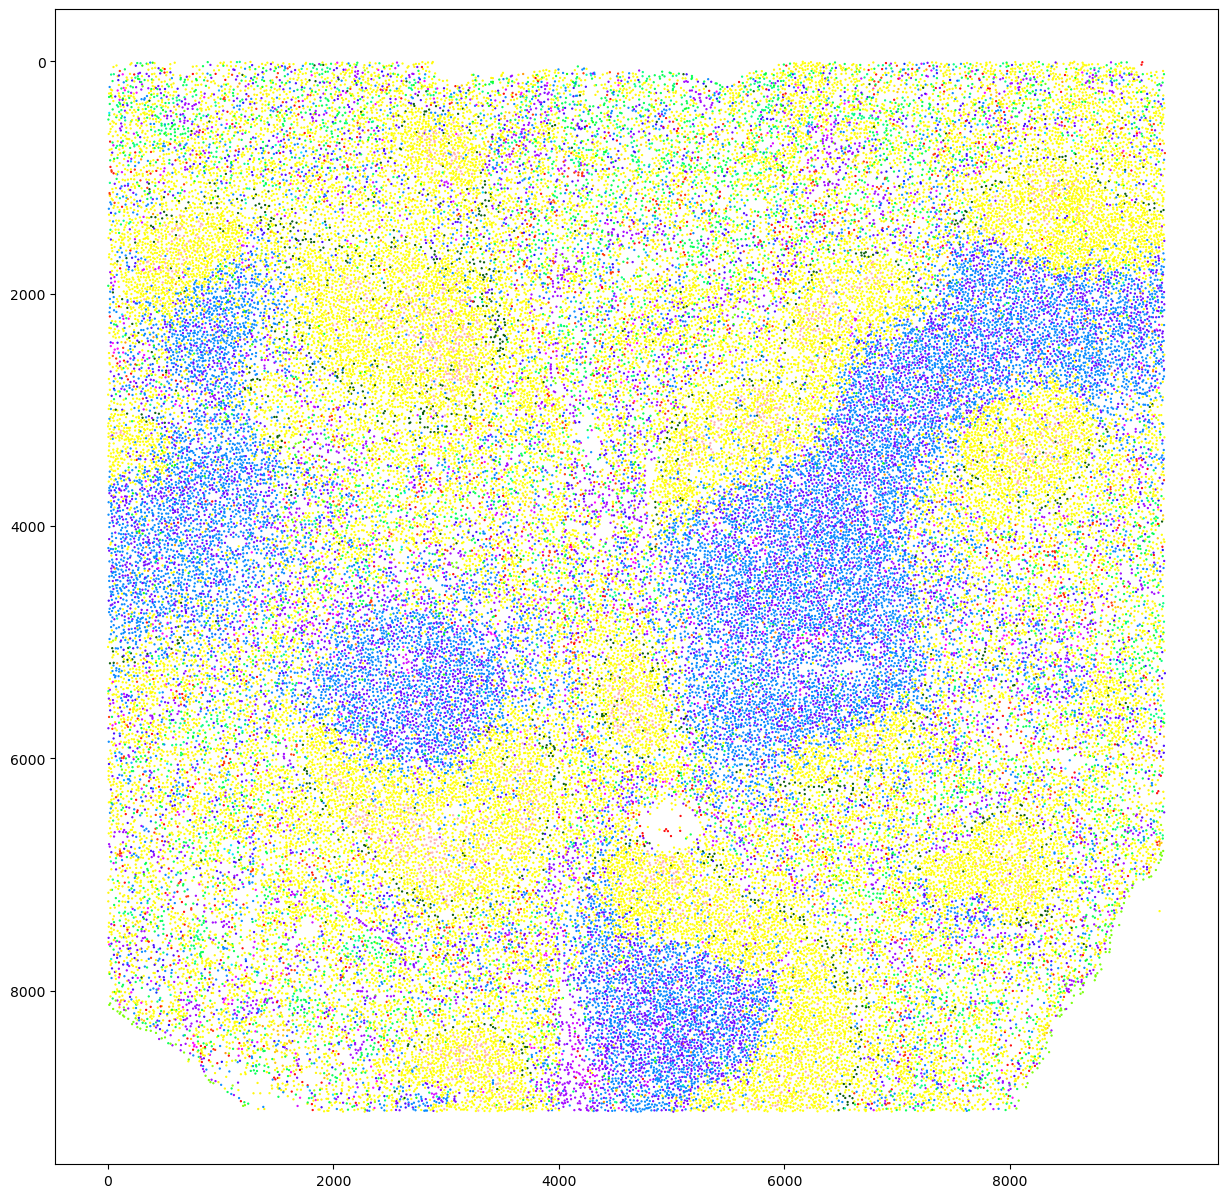

In [27]:
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(15,15))

#cmap = get_cmap(len(df2['cell_type'].unique()))
plt.scatter(df3['X1_adjusted'], df3['Y1_adjusted'],s=0.4, c=df3['color'].to_list(), marker='o')
plt.gca().invert_yaxis()
#plt.savefig('/Users/ethan/Desktop/test.png', dpi=300)
plt.show()

In [29]:
pos = []
for i in df3.index.tolist():
    x = df2.loc[i, 'X1_adjusted']
    y = df3.loc[i, 'Y1_adjusted']
    p = [x, y]
    pos.append(p)

position_dict = dict(zip(df3['source_id'].tolist(),pos))
G = nx.from_edgelist(edgelist)

In [33]:
def build_assignment_matrix(attribute_dict, n_cell_types):
    data = list(attribute_dict.items())
    data = np.array(data)  # Assignment matrix

    B = np.zeros((data.shape[0], n_cell_types))  # Empty matrix

    for i in range(0, data.shape[0]):
        t = data[i, 1]
        B[i, int(t)] = 1

    return B
    
def parse_pair_arr_to_tuple(arr):
    
    if len(arr) != 0: 
        enriched_pairs = list(arr[:,0:2].astype(int))
        x = []
        for i in enriched_pairs:
            x.append((i[0], i[1]))

        return x
    else:
        return []

def run_test(results_path, A, B, H_gt, size, n_jobs, trials, plot, graph, graph_id, threshold):
    '''
    Runs the permutation test, and calculates signficant interaction pairs.

    Parameters
    ----------
        results_path: str, the root results dir
        size : int, size of graph to calculate.
        n_jobs: int, number of parallel jobs to spawn
        trials: int, number of shuffles in empirical distribution
        plot : bool, generate histogram of each pairwise relation if True.

    Returns
    -------
        None
    '''
    # Make results dir
    try:
        os.mkdir(results_path)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass

    # Perform calculations.
    results = []
    if graph_id == None:
        out_dir = results_path + str(size) + '_cells/'
    else:
        out_dir = results_path + str(size) + '_cells_' + str(graph_id) + '/'

    try:
        os.mkdir(out_dir)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass
    
    n_cell_types = B.shape[1]
    args = (A, B, size, graph, n_cell_types)
    arg_list = [args for i in range(0, trials)]
    results = Parallel(n_jobs=n_jobs, verbose=1, backend="sequential")(
        delayed(perm_test.permutation_test_trial_wrapper)(args) for args in arg_list)
    #parse_results(results, size, out_dir)

    # Process results

    '''# size_list = []
    result_list = []

    file_list = glob(out_dir + '*.npy')
    for f in file_list:
        arr = np.load(f)
        # size_list.append(size)
        result_list.append(arr)'''

    arr = np.dstack(results)  # stack into a 3-D array
    n_types = arr.shape[0]

    enriched_pairs = []
    depleted_pairs = []

    for i in range(0, n_types):
        for j in range(0, n_types):
            ground_truth_score = H_gt[i, j]
            emp_dist = arr[i, j, :]
            indices, = np.where(emp_dist < ground_truth_score)
            p = (len(emp_dist) - len(indices) + 1) / (len(emp_dist) + 1)
            if p <= threshold:
                enriched_pairs.append([i, j, p])
            elif p >= 1 - threshold:
                depleted_pairs.append([i, j, p])

            # Visualize empirical distribution
            if plot == True:
                plt.clf()
                # sns.set(style = 'white')
                plt.hist(arr[2, 2, :], color='k')
                plt.xlim(0, 1)
                plt.xlabel("Probability of Interaction between " + str(i) + " and " + str(j))
                plt.ylabel("Count")
                plt.savefig(out_dir + "distplot_" + str(i) + "_" + str(j) + ".pdf")

    # Write results matrix.
    np.save(out_dir + "enriched_pairs.npy", np.array(enriched_pairs))
    np.save(out_dir + "depleted_pairs.npy", np.array(depleted_pairs))

    return

def run_test_nosave(A, B, H_gt, size, n_jobs, trials, graph, threshold):
    '''
    Runs the permutation test, and calculates signficant interaction pairs.

    Parameters
    ----------
        size : int, size of graph to calculate.
        n_jobs: int, number of parallel jobs to spawn
        trials: int, number of shuffles in empirical distribution
        plot : bool, generate histogram of each pairwise relation if True.

    Returns
    -------
        enriched_pairs  :   array-like
        depleted_pairs  :   array-like
    '''
   
    n_cell_types = B.shape[1]
    args = (A, B, size, graph, n_cell_types)
    arg_list = [args for i in range(0, trials)]
    results = Parallel(n_jobs=n_jobs, verbose=0, backend="sequential")(
        delayed(perm_test.permutation_test_trial_wrapper)(args) for args in arg_list)
    #parse_results(results, size, out_dir)

    arr = np.dstack(results)  # stack into a 3-D array
    n_types = arr.shape[0]

    enriched_pairs = []
    depleted_pairs = []

    for i in range(0, n_types):
        for j in range(0, n_types):
            ground_truth_score = H_gt[i, j]
            emp_dist = arr[i, j, :]
            indices, = np.where(emp_dist < ground_truth_score)
            p = (len(emp_dist) - len(indices) + 1) / (len(emp_dist) + 1)
            if p <= threshold:
                enriched_pairs.append([i, j, p])
            elif p >= 1 - threshold:
                depleted_pairs.append([i, j, p])

    # Write results matrix.
    #np.save(out_dir + "enriched_pairs.npy", np.array(enriched_pairs))
    #np.save(out_dir + "depleted_pairs.npy", np.array(depleted_pairs))

    return enriched_pairs, depleted_pairs

#### In random FOVs, how often do we see the key interaction (14/16)

In [40]:
min_x = min(df3['X1_adjusted'])
max_x = max(df3['X1_adjusted'])
min_y = min(df3['Y1_adjusted'])
max_y = max(df3['Y1_adjusted'])

print(min_x, max_x)
print(min_y, max_y)

1 9375
4 9041


In [41]:
sampling_frac = 0.075

def calculate_FOV_size(sampling_frac, min_x, max_x, min_y, max_y):
    area = (max_x - min_x) * (max_y - min_y)
    sampling_area = sampling_frac * area
    FOV_dim = np.round(np.sqrt(sampling_area))
    return FOV_dim

In [42]:
FOV_dim = calculate_FOV_size(sampling_frac, min_x, max_x, min_y, max_y)
FOV_dim

2521.0

In [43]:
def random_FOV(FOV_dim, df, min_x, max_x, min_y, max_y):
    x_start = np.random.randint(min_x, max_x - FOV_dim)
    y_start = np.random.randint(min_y, max_y - FOV_dim)
    
    x_filtered = df[(df['X1_adjusted'] > x_start) & (df['X1_adjusted'] < x_start + FOV_dim)]
    random_FOV = x_filtered[(x_filtered['Y1_adjusted'] > y_start) & (x_filtered['Y1_adjusted'] < y_start + FOV_dim)]
    
    return random_FOV
    
def random_FOV_plot(FOV_dim, df, min_x, max_x, min_y, max_y):
    x_start = np.random.randint(min_x, max_x - FOV_dim)
    y_start = np.random.randint(min_y, max_y - FOV_dim)
    
    x_filtered = df[(df['X1_adjusted'] > x_start) & (df['X1_adjusted'] < x_start + FOV_dim)]
    random_FOV = x_filtered[(x_filtered['Y1_adjusted'] > y_start) & (x_filtered['Y1_adjusted'] < y_start + FOV_dim)]
    
    x_coords = [x_start, x_start + FOV_dim]
    y_coords = [y_start, y_start + FOV_dim]
    return random_FOV, x_coords, y_coords

In [45]:
fov_list = []
x_coord_list = []
y_coord_list = []

for i in range(0, 50):
    fov, x_coords, y_coords = random_FOV_plot(FOV_dim, df3, min_x, max_x, min_y, max_y)
    fov_list.append(fov)
    x_coord_list.append(x_coords)
    y_coord_list.append(y_coords)

In [68]:
out_dir = './spleen_data/for_paper/full'

In [78]:
def detect_enrichments(fov):
    
    attribute_dict = dict(zip(fov['source_id'], fov['cell_type']))
    full_graph2 = full_graph.subgraph(fov['source_id'])
    A = nx.convert_matrix.to_scipy_sparse_matrix(full_graph2)
    B = build_assignment_matrix(attribute_dict, 28)
    p = np.divide(np.sum(B, axis=0), A.shape[0])
    H = perm_test.calculate_neighborhood_distribution_sparse(A, B)
    
    #out_dir = './spleen_data/for_paper/full'
    #now = datetime.now()
    #datestamp = date_time = now.strftime("%m%d%Y")
    #results_path = str(out_dir) + '/neighborhood_perm_test_' + str(datestamp) + '/

    enrichment_pairs, avoidance_pairs = run_test_nosave(A, B, H, A.shape[0], n_jobs=1, trials=500, graph=full_graph2, threshold = 0.01)
    return enrichment_pairs

In [80]:
enrichment_list = []
for i in tqdm.tqdm(fov_list):
    enrichment_list.append(detect_enrichments(i))

  0%|          | 0/50 [00:00<?, ?it/s]/Users/ethan/Dropbox (MIT)/Lab/spatial-data-generation_brokengit/circle_packing/spatialpower/neighborhoods/permutationtest.py:170: RuntimeWarning: divide by zero encountered in true_divide
  aux1 = 1/edge_count_by_node
/Users/ethan/Dropbox (MIT)/Lab/spatial-data-generation_brokengit/circle_packing/spatialpower/neighborhoods/permutationtest.py:177: RuntimeWarning: divide by zero encountered in true_divide
  aux2 = 1/cell_type_counts
100%|██████████| 50/50 [21:34<00:00, 25.89s/it]


In [81]:
detected = []

for e in enrichment_list:
    tuples = parse_pair_arr_to_tuple(np.array(e))
    if (14, 16) in tuples or (16, 14) in tuples:
        detected.append(1)
    else:
        detected.append(0)


In [83]:
fovdim = 2521
idx = np.where(detected)
idx = idx[0]

import matplotlib

plt.clf()
matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(df3['X1_adjusted'], df3['Y1_adjusted'],s=0.3, c=df3['color'].to_list(), marker='o')


#plt.ylim(y_min, y_max)


for i in range(0, 50):
    if i in idx:
        rect = Rectangle((x_coord_list[i][0], y_coord_list[i][0]), fovdim, fovdim,linewidth=3,edgecolor='g',facecolor='none')
        ax.add_patch(rect)
    else:
        rect = Rectangle((x_coord_list[i][0], y_coord_list[i][0]), fovdim, fovdim,linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
ax.set_aspect('equal')
ax.set_xlim([0, max(df3['X1_adjusted'])])

plt.gca().invert_yaxis()
#plt.savefig('./spleen_data/for_paper/FOVdraws_0.075_vTMA.pdf')
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
results_1 = []
results_25 = []
results_5 = []
results_75 = [] #7.5
results_10 = []

FOV_dim = calculate_FOV_size(0.01, min_x, max_x, min_y, max_y)
for i in tqdm.trange(0, 100):
    fov = random_FOV(FOV_dim, df3, min_x, max_x, min_y, max_y)
    enrichment_pairs = detect_enrichments(fov)
    results_1.append(enrichment_pairs)

FOV_dim = calculate_FOV_size(0.025, min_x, max_x, min_y, max_y)
for i in tqdm.trange(0, 100):
    fov = random_FOV(FOV_dim, df3, min_x, max_x, min_y, max_y)
    enrichment_pairs = detect_enrichments(fov)
    results_1.append(enrichment_pairs)
    
FOV_dim = calculate_FOV_size(0.05, min_x, max_x, min_y, max_y)
for i in tqdm.trange(0, 100):
    fov = random_FOV(FOV_dim, df3, min_x, max_x, min_y, max_y)
    enrichment_pairs = detect_enrichments(fov)
    results_5.append(enrichment_pairs)

FOV_dim = calculate_FOV_size(0.1, min_x, max_x, min_y, max_y)
for i in tqdm.trange(0, 100):
    fov = random_FOV(FOV_dim, df3, min_x, max_x, min_y, max_y)
    enrichment_pairs = detect_enrichments(fov)
    results_10.append(enrichment_pairs)

FOV_dim = calculate_FOV_size(0.075, min_x, max_x, min_y, max_y)
for i in tqdm.trange(0, 100):
    fov = random_FOV(FOV_dim, df3, min_x, max_x, min_y, max_y)
    enrichment_pairs = detect_enrichments(fov)
    results_75.append(enrichment_pairs)

In [222]:
contained_pair_1 = []
contained_pair_5 = []
contained_pair_75 = []
contained_pair_10 = []

for i in range(0, len(results_1)):
    if len(results_1[i]) == 0:
        r = 0
        
    else:
        A=np.array(results_1[i])[:,:2]
        if len((np.where((A==(14,16)).all(axis=1))[0]) >= 1) or len((np.where((A==(16,14)).all(axis=1))[0]) >= 1):
            #Found
            r = 1
        else:
            r = 0
            
    contained_pair_1.append(r)
    
for i in range(0, len(results_5)):
    if len(results_5[i]) == 0:
        r = 0
    
    else:
        A=np.array(results_5[i])[:,:2]
        if len((np.where((A==(14,16)).all(axis=1))[0]) >= 1) or len((np.where((A==(16,14)).all(axis=1))[0]) >= 1):
            #Found
            r = 1
        else:
            r = 0
            
    contained_pair_5.append(r)

for i in range(0, len(results_75)):
    if len(results_75[i]) == 0:
        r = 0
        
    else:
        A=np.array(results_75[i])[:,:2]
        if len((np.where((A==(14,16)).all(axis=1))[0]) >= 1) or len((np.where((A==(16,14)).all(axis=1))[0]) >= 1):
            #Found
            r = 1
        else:
            r = 0
            
    contained_pair_75.append(r)
    
for i in range(0, len(results_10)):
    if len(results_10[i]) == 0:
        r = 0
        
    else:
        A=np.array(results_10[i])[:,:2]
        if len((np.where((A==(14,16)).all(axis=1))[0]) >= 1) or len((np.where((A==(16,14)).all(axis=1))[0]) >= 1):
            #Found
            r = 1
        else:
            r = 0
            
    contained_pair_10.append(r)

In [80]:
nx.write_gpickle(full_graph, './full_graph.pkl')

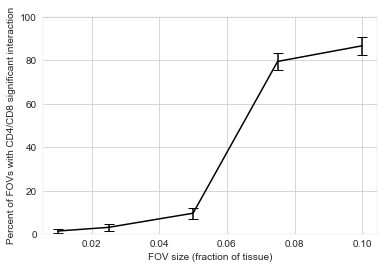

In [111]:
import matplotlib
from matplotlib import cm, colors
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})

#Manually imported results here from UGER TODO:automate

fracs_01 = np.array([0,1,0,2,2,2,2,1,3,2])
fracs_025 = np.array([3,4,4,5,6,2,2,3,1,2])
fracs_05 = np.array([8,7,7,8,10,10,13,9,15,10])
fracs_075 = np.array([80,81,76,75,79,82,87,76,84,75])
fracs_10 = np.array([92,86,89,86,86,92,83,88,88,77])

x = [0.01, 0.025, 0.05, 0.075, 0.1]
ys = [fracs_01, fracs_025, fracs_05, fracs_075, fracs_10]

means = []
errs = []
for arr in ys:
    means.append(np.mean(arr))
    errs.append(np.std(arr))

means = np.array(means)
errs = np.array(errs)
ci = 1.96 * errs/means

sns.set_style('whitegrid')
sns.set_palette('colorblind')
plt.errorbar(x, means, yerr=errs, capsize=5, color = 'k')
plt.ylabel(r'Percent of FOVs with CD4/CD8 significant interaction')
plt.xlabel(r'FOV size (fraction of tissue)')
plt.ylim(0,100)
#plt.savefig('./spleen_data/figures/FigureS3_20210411_std.pdf')
plt.show()

In [227]:
np.save('./results/results_1.npy', results_1)
np.save('./results/results_5.npy', results_5)
np.save('./results/results_75.npy', results_75)
np.save('./results/results_10.npy', results_10)

/Users/ethan/anaconda3/envs/spatialdata/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
def grey_colors(cell_type):
    if cell_type == 2:
        #use the actual color
        color = color_list[cell_type]
    else:
        #grey 
        color = '#cdcdd1'
    return color


df3['rev_cell_type'] = df3['cell_type'].apply(lambda x: x - 1 if x > 6 else x)
df4 = df3.copy()
df4['grey_color'] = df4['rev_cell_type'].apply(lambda x: grey_colors(x))
df_grey = df4[df4['grey_color'] == '#cdcdd1']
df_cd8 = df4[df4['rev_cell_type'] == 13] #the cd4/cd16 cell id should has changed from 14/16 to 13/15
df_cd4 = df4[df4['rev_cell_type'] == 15]

In [52]:
import matplotlib
from matplotlib import cm, colors
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})
plt.clf()

fig, ax = plt.subplots(1, 1, figsize=(10,10))

#cmap = get_cmap(len(df2['cell_type'].unique()))
plt.scatter(df_grey['X1_adjusted'], df_grey['Y1_adjusted'],s=1, c=df_grey['grey_color'].to_list(), marker='o', alpha = 0.6)
plt.scatter(df_cd4['X1_adjusted'], df_cd4['Y1_adjusted'],s=2, c=df_cd4['color'].to_list(), marker='o', label=r'CD4(+)')
plt.scatter(df_cd8['X1_adjusted'], df_cd8['Y1_adjusted'],s=2, c=df_cd8['color'], marker='o', label=r'CD8(+)')

plt.gca().invert_yaxis()
plt.legend(loc='lower left')
#plt.savefig('./spleen_data/figures/FigureS6B.pdf')
plt.show()

<Figure size 640x480 with 0 Axes>